In [89]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.append('../helpers/')

import pickle

from pathlib import Path
import numpy as np
import pandas as pd
import os
from glob import glob
import natsort
import cv2
import csv
import random
from tqdm import tqdm

import matplotlib.pyplot as plt

# importing packages
from preprocessing import Preprocessing
from feature_extraction import FeatureExtraction

preprocessor = Preprocessing()
feature_extractor = FeatureExtraction()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ROOT_PATH = Path(Path(os.getcwd())/"../challenge2")
TRAIN_PATH = ROOT_PATH/"train"
VAL_PATH = ROOT_PATH/"val"

train_bcc = sorted(glob(str(TRAIN_PATH/'bcc/*')))
train_mel = sorted(glob(str(TRAIN_PATH/'mel/*')))
train_scc = sorted(glob(str(TRAIN_PATH/'scc/*')))

val_bcc = sorted(glob(str(VAL_PATH/'bcc/*')))
val_mel = sorted(glob(str(VAL_PATH/'mel/*')))
val_scc = sorted(glob(str(VAL_PATH/'scc/*')))

### SAVING PICKLES OF PREPROCESSED IMAGES

In [3]:
# Pre-processing and feature extraction
prep_imgs_dir = r'../output/'

bcc_train_prep_filename    = 'bcc_train_prep_images.pkl'
bcc_val_prep_filename      = 'bcc_val_prep_images.pkl'

mel_train_prep_filename   = 'mel_train_prep_images.pkl'
mel_val_prep_filename     = 'mel_val_prep_images.pkl'

scc_train_prep_filename   = 'scc_train_prep_images.pkl'
scc_val_prep_filename     = 'scc_val_prep_images.pkl'


filenames_prep_list = [bcc_train_prep_filename, bcc_val_prep_filename, mel_train_prep_filename,  mel_val_prep_filename, scc_train_prep_filename, scc_val_prep_filename]
dir_list = [train_bcc, val_bcc, train_mel, val_mel, train_scc, val_scc]

In [14]:
subsample               = False

for index, filename in enumerate(filenames_prep_list):

    preprocessed_images = []

    for count, image_path in tqdm(enumerate(dir_list[index])):

        if subsample:
            if count == 999: # only 1k per class
                break

        # reading the image 
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)

        # 1. Copping black frame
        image_without_black_frame, _ = preprocessor.crop_frame(image)

        # 2. Resizing
        image_resized = preprocessor.resize_images(image_without_black_frame, preserve_ratio=True)

        # 3. Removing hair
        image_without_hair = preprocessor.extract_hair(image_resized)

        # Saving the preprocessed image to a list
        preprocessed_images.append(image_without_hair)

    # Saving the preprocessed images to a file
    with open(prep_imgs_dir+filename, 'wb') as file:
        pickle.dump(preprocessed_images, file)

1993it [13:20,  2.49it/s]
170it [00:59, 10.06it/s]c:\master\udg\CAD\project\notebooks\../helpers\preprocessing.py:128: RuntimeWarning: divide by zero encountered in scalar divide
  if mean_outside / mean_inside < threshold:
498it [02:54,  2.85it/s]
376it [02:09,  2.89it/s]
94it [00:36,  2.59it/s]


### EXTRACTING FEATURES FROM PREPROCESSED IMAGES SAVED IN PICKLES

In [17]:
# LOADING PICKLES 

with open(os.path.join(prep_imgs_dir, mel_train_prep_filename), 'rb') as file:
    mel_train_prep_images = pickle.load(file)
with open(os.path.join(prep_imgs_dir, mel_val_prep_filename), 'rb') as file:
    mel_val_prep_images = pickle.load(file)

with open(os.path.join(prep_imgs_dir, bcc_train_prep_filename), 'rb') as file:
    bcc_train_prep_images = pickle.load(file)
with open(os.path.join(prep_imgs_dir, bcc_val_prep_filename), 'rb') as file:
    bcc_val_prep_images = pickle.load(file)

with open(os.path.join(prep_imgs_dir, scc_train_prep_filename), 'rb') as file:
    scc_train_prep_images = pickle.load(file)
with open(os.path.join(prep_imgs_dir, scc_val_prep_filename), 'rb') as file:
    scc_val_prep_images = pickle.load(file)

In [20]:
# Pre-processing and feature extraction
features_dir = r'../output/features/'

experiment              = 0
subsample               = False

bcc_train_filename    = f'{experiment}_bcc_train_features.csv'
bcc_val_filename      = f'{experiment}_bcc_val_features.csv'

mel_train_filename    = f'{experiment}_mel_train_features.csv'
mel_val_filename      = f'{experiment}_mel_val_features.csv'

scc_train_filename   = f'{experiment}_scc_train_features.csv'
scc_val_filename     = f'{experiment}_scc_val_features.csv'

filenames_list = [bcc_train_filename, bcc_val_filename, mel_train_filename, mel_val_filename, scc_train_filename, scc_val_filename]
images_lists = [bcc_train_prep_images, bcc_val_prep_images, mel_train_prep_images, mel_val_prep_images, scc_train_prep_images, scc_val_prep_images]

labels = [0, 0, 1, 1, 2, 2] # bcc = 0, mel = 1, scc = 2


# Loop through the lists of images and their corresponding filenames
for filename, image_list, label in zip(filenames_list, images_lists, labels):
    with open(os.path.join(features_dir, filename), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        for count, preprocessed_image in tqdm(enumerate(image_list)):
            if subsample and count == 999:  # Only 1k per class
                break

            # 5. Extracting features
            feature_vector = feature_extractor.fit(preprocessed_image)

            # 6. Add label column
            feature_vector = np.append(feature_vector, label)

            # Write the feature vector to the CSV file
            writer.writerow(feature_vector)

376it [09:59,  1.59s/it]
94it [02:15,  1.44s/it]


### PREPARING THE DATA FOR MACHINE LEARNING

In [90]:
import pandas as pd

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix, balanced_accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from feature_selection import FeatureSelection

import pprint

select_feature = FeatureSelection()

In [4]:
features_dir = r'../output/features/'
experiment              = 0

train_bcc_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_bcc_train_features.csv'),  header = None)
val_bcc_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_bcc_val_features.csv'),  header = None)

train_mel_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_mel_train_features.csv'),  header = None)
val_mel_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_mel_val_features.csv'),  header = None)

train_scc_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_scc_train_features.csv'),  header = None)
val_scc_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_scc_val_features.csv'),  header = None)

In [5]:
# Concatenate the 'bcc', 'mel' and 'scc' dataframes
train_features = pd.concat([train_bcc_df, train_mel_df, train_scc_df], ignore_index=True)
val_features = pd.concat([val_bcc_df, val_mel_df, val_scc_df], ignore_index=True)

# Shuffle the dataset
train_features = train_features.sample(frac=1, random_state=42)
val_features = val_features.sample(frac=1, random_state=42)

In [6]:
X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]

X_val = val_features.iloc[:,:-1]
y_val = val_features.iloc[:,-1]

In [7]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_val_normalized = pd.DataFrame(scaler.transform(X_val))

In [8]:
# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

In [37]:
print(f"X_train_normalized.shape: {X_train_normalized.shape}")

X_train_normalized.shape: (5082, 104)


### Exploratory Data Analysis (EDA)

Understanding the class unbalance before resampling techniques

In [75]:
def create_class_distribution_bar_chart(dataframe, title="Class Distribution Bar Chart"):
    """
    Create a bar chart to visualize the distribution of classes in the last column of a Pandas DataFrame with titles for each class.

    Parameters:
    - dataframe: Pandas DataFrame containing the data.
    - title: Title for the bar chart (optional).

    Returns:
    - None (displays the class distribution bar chart with titles).
    """
    # Extract the last column (class labels)
    class_labels = dataframe.iloc[:, -1]

    # Count the occurrences of each class
    class_counts = class_labels.value_counts()

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    ax = class_counts.plot(kind='bar')
    
    # Set chart title and labels
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    
    # Add titles to each class column
    for i, count in enumerate(class_counts):
        ax.text(i, count, str(count), ha='center', va='bottom')

    # Display the chart
    plt.show()

Total amount of training data is: 5082 


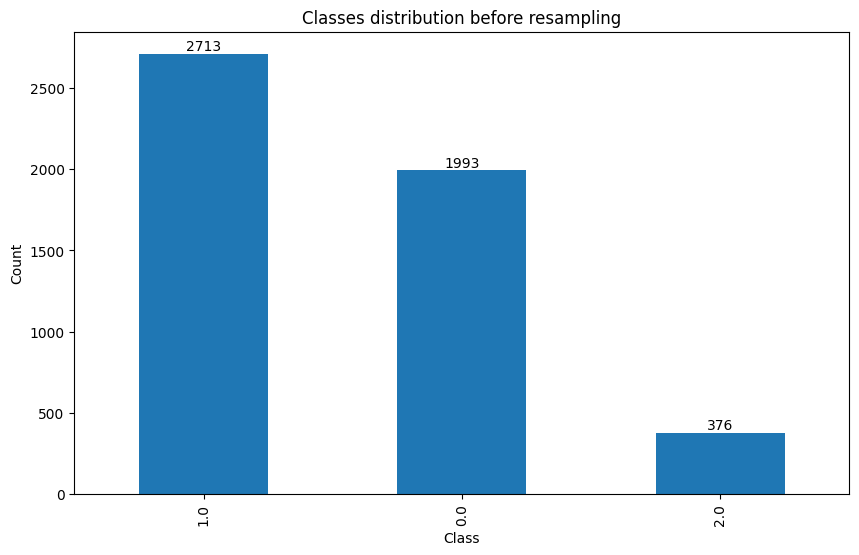

In [81]:
print(f"Total amount of training data is: {train_features.shape[0]} ")
create_class_distribution_bar_chart(train_features, title='Classes distribution before resampling')

### Handling class imbalance using oversampling minority classes, SMOTE, and undersampling to majority classes

In [12]:
# Apply oversampling to minority classes
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_normalized, y_train_encoded)

# Apply SMOTE for synthetic data generation
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_oversampled, y_train_oversampled)

# Apply undersampling to majority classes
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)


In [73]:
# type(y_train_resampled)
y_train_resampled_df    = pd.Series(y_train_resampled)
X_train_resampled_full  =  pd.concat([X_train_resampled, y_train_resampled_df], axis=1)

(8139, 105)

Total amount of training data is: 8139 


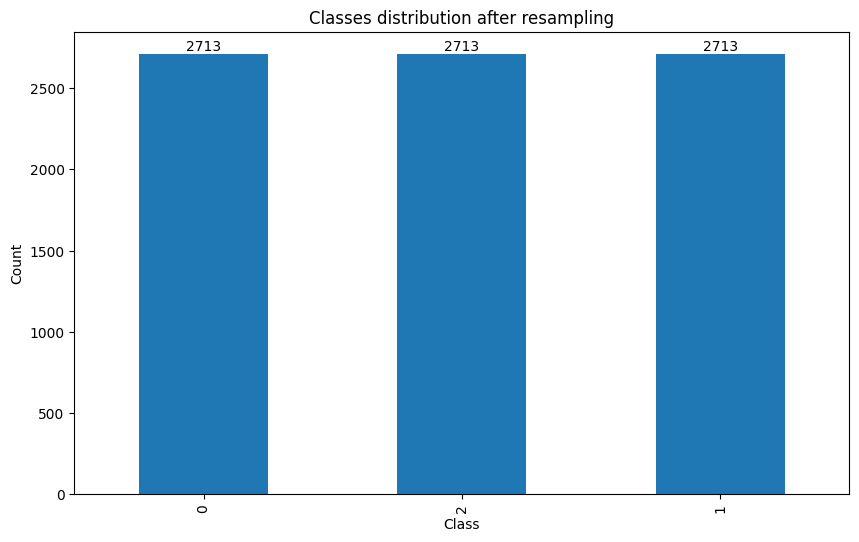

In [87]:
print(f"Total amount of training data is: {X_train_resampled_full.shape[0]} ")
create_class_distribution_bar_chart(X_train_resampled_full, title='Classes distribution after resampling')

### CLASSIFICATION

In [109]:
def compare_models(models, param_grids, X_train, y_train, X_val, y_val, scoring_metric='accuracy', cv=10):
    all_models = []
    
    for model, param_grid in zip(models, param_grids):
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=2, scoring=scoring_metric)
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        # Store the best model and its parameters
        all_models.append({'model': best_model, 'params': best_params})
    
    # Evaluate the best models on a separate validation set
    models_report = []
    for model_info in all_models:
        model = model_info['model']
        y_pred = model.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
        weighted_f1 = f1_score(y_val, y_pred, average='weighted')

        report = dict()
                
        report['model'] = model
        report['best_params'] = model_info['params']
        report['accuracy'] = accuracy
        report['balanced_accuracy'] = balanced_accuracy
        report['weighted_f1'] = weighted_f1


        conf_matrix = multilabel_confusion_matrix(y_val_encoded, y_pred)
        classes = ['bcc', 'mel', 'scc']
        for i, class_label in enumerate(classes):
            tp = conf_matrix[i, 1, 1]
            fp = conf_matrix[i, 0, 1]
            fn = conf_matrix[i, 1, 0]
            tn = conf_matrix[i, 0, 0]

            specificity = tn / (tn + fp)
            sensitivity = tp / (tp + fn)
            precision = tp / (tp + fp)
            f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

            binary_true_labels = np.where(np.array(y_val) == i, 1, 0)
            binary_predicted_labels = np.where(np.array(y_pred) == i, 1, 0)
            fpr, tpr, _ = roc_curve(binary_true_labels, binary_predicted_labels)
            roc_auc = auc(fpr, tpr)

            report[f'{class_label}_specificity'] = specificity
            report[f'{class_label}_sensitivity'] = sensitivity
            report[f'{class_label}_precision']  = precision
            report[f'{class_label}_f1'] = f1
            report[f'{class_label}_roc_auc'] = roc_auc

        models_report.append(report)
        
        models_report.sort(key=lambda x: x['accuracy'], reverse=True)
    
    # return best_model, best_score, best_params, all_models
    return models_report

In [113]:
# Define the list of models and their respective hyperparameter grids
models = [
    SVC(decision_function_shape='ovr', class_weight='balanced'),
    LogisticRegression(multi_class = 'ovr', class_weight='balanced'),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    LinearDiscriminantAnalysis(),
    XGBClassifier()
    ] 
        

param_grids = [
    {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1]},
    {'penalty' : ['l1', 'l2'], 'C':[0.1, 1, 10], 'solver': ['liblinear']},
    {'n_neighbors': [3, 5, 7, 9], 'weights' : ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]}, 
    {'n_estimators' : [50, 100, 200], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}, # still takes a lot of time
    {'solver': ['svd', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 1.0]},
    {'max_depth': [4, 5], 'learning_rate': [0.1, 0.01], 'n_estimators': [200, 300], 'subsample': [0.5, 0.7, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]}
]

# Call the function to compare models and get the best one
# models_report = compare_models(models, param_grids, X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, scoring_metric='f1_weighted', cv=5)

# Training with the resampled training data X_train_resampled, y_train_resampled
models_report = compare_models(models, param_grids, X_train_resampled, y_train_resampled, X_val_normalized, y_val_encoded, scoring_metric='f1_weighted', cv=5)

# Save the best model to a file
# best_model_filename = ROOT_PATH/'best_model.pkl'
# with open(best_model_filename, 'wb') as file:
#     pickle.dump(best_model, file)

print("Model Report:", models_report)
# print("Best Score:", best_score)
# print("Best Params:", best_params)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   1.8s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   2.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   1.9s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   1.7s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   1.8s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   2.9s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   3.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   3.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   3.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   3.1s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   1.9s
[CV] END ...................C=0.1, gamma=0.01, k

In [114]:
print(np.array(models_report).shape)
print(models_report)

(6,)
[{'model': SVC(C=10, class_weight='balanced', gamma=0.1), 'best_params': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, 'accuracy': 0.8299212598425196, 'balanced_accuracy': 0.7092838812729106, 'weighted_f1': 0.8244582917416435, 'bcc_specificity': 0.8795336787564767, 'bcc_sensitivity': 0.8132530120481928, 'bcc_precision': 0.8132530120481928, 'bcc_f1': 0.8132530120481927, 'bcc_roc_auc': 0.8463933454023347, 'mel_specificity': 0.8175675675675675, 'mel_sensitivity': 0.8997050147492626, 'mel_precision': 0.8495821727019499, 'mel_f1': 0.8739255014326647, 'mel_roc_auc': 0.8586362911584151, 'scc_specificity': 0.9872448979591837, 'scc_sensitivity': 0.4148936170212766, 'scc_precision': 0.7222222222222222, 'scc_f1': 0.527027027027027, 'scc_roc_auc': 0.7010692574902301}, {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_ca

In [116]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(models_report)


[   {   'accuracy': 0.8299212598425196,
        'balanced_accuracy': 0.7092838812729106,
        'bcc_f1': 0.8132530120481927,
        'bcc_precision': 0.8132530120481928,
        'bcc_roc_auc': 0.8463933454023347,
        'bcc_sensitivity': 0.8132530120481928,
        'bcc_specificity': 0.8795336787564767,
        'best_params': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'},
        'mel_f1': 0.8739255014326647,
        'mel_precision': 0.8495821727019499,
        'mel_roc_auc': 0.8586362911584151,
        'mel_sensitivity': 0.8997050147492626,
        'mel_specificity': 0.8175675675675675,
        'model': SVC(C=10, class_weight='balanced', gamma=0.1),
        'scc_f1': 0.527027027027027,
        'scc_precision': 0.7222222222222222,
        'scc_roc_auc': 0.7010692574902301,
        'scc_sensitivity': 0.4148936170212766,
        'scc_specificity': 0.9872448979591837,
        'weighted_f1': 0.8244582917416435},
    {   'accuracy': 0.8031496062992126,
        'balanced_accuracy': 0.65644766

In [12]:
# Save the best model to a file
# best_model_filename = r'../models/best_model_multiclassSVM.pkl'
# with open(best_model_filename, 'wb') as file:
#      pickle.dump(best_model, file)